# Method 9 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

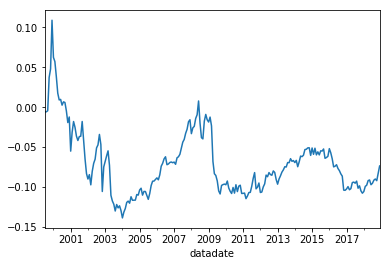

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.109044
2000-12-31   -0.109420
2001-12-31   -0.071859
2002-12-31    0.009058
2003-12-31   -0.059058
2004-12-31    0.022191
2005-12-31    0.021977
2006-12-31    0.023162
2007-12-31    0.057929
2008-12-31   -0.000017
2009-12-31   -0.081973
2010-12-31   -0.013013
2011-12-31    0.014719
2012-12-31    0.004867
2013-12-31    0.026113
2014-12-31    0.006946
2015-12-31   -0.001221
2016-12-31   -0.045453
2017-12-31   -0.004047
2018-12-31    0.038273
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     29.16
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-19
Time:                        20:25:42   Log-Likelihood:                 749.76
No. Observations:                 234   AIC:                            -1490.
Df Residuals:                     229   BIC:                            -1472.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.699      0.485      -0.002       0.001
mktrf         -0.0301      0.019     -1.625      0.105      -0.067       0.006
me            -0.0111      0.022     -0.516      0.606      -0.054       0.031
ia            -0.1774      0.033     -5.417      0.000      -0.242      -0.113
roe            0.2034      0.028      7.257      0.000       0.148       0.259
==============================================================================
Omnibus:                       58.067   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.174
Skew:                           0.448   Prob(JB):                    2.64e-177
Kurtosis:                      12.088   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     10.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.06e-08
Time:                        20:25:42   Log-Likelihood:                 749.76
No. Observations:                 234   AIC:                            -1490.
Df Residuals:                     229   BIC:                            -1472.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.684      0.494      -0.002       0.001
mktrf         -0.0301      0.022     -1.339      0.181      -0.074       0.014
me            -0.0111      0.026     -0.433      0.665      -0.061       0.039
ia            -0.1774      0.074     -2.403      0.016      -0.322      -0.033
roe            0.2034      0.051      4.019      0.000       0.104       0.303
==============================================================================
Omnibus:                       58.067   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.174
Skew:                           0.448   Prob(JB):                    2.64e-177
Kurtosis:                      12.088   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     9.411
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.64e-07
Time:                        20:25:42   Log-Likelihood:                 749.76
No. Observations:                 234   AIC:                            -1490.
Df Residuals:                     229   BIC:                            -1472.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.608      0.543      -0.002       0.001
mktrf         -0.0301      0.022     -1.362      0.173      -0.073       0.013
me            -0.0111      0.027     -0.417      0.677      -0.063       0.041
ia            -0.1774      0.067     -2.631      0.009      -0.309      -0.045
roe            0.2034      0.053      3.867      0.000       0.100       0.306
==============================================================================
Omnibus:                       58.067   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              813.174
Skew:                           0.448   Prob(JB):                    2.64e-177
Kurtosis:                      12.088   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     14.21
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.21e-12
Time:                        20:25:42   Log-Likelihood:                 733.33
No. Observations:                 234   AIC:                            -1455.
Df Residuals:                     228   BIC:                            -1434.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.209      0.835      -0.001       0.002
mktrf         -0.0698      0.020     -3.500      0.001      -0.109      -0.031
smb           -0.0306      0.026     -1.162      0.246      -0.082       0.021
hml           -0.0818      0.031     -2.635      0.009      -0.143      -0.021
rmw            0.1021      0.035      2.908      0.004       0.033       0.171
cma           -0.0928      0.045     -2.082      0.039      -0.181      -0.005
==============================================================================
Omnibus:                       47.739   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.891
Skew:                           0.019   Prob(JB):                    1.26e-146
Kurtosis:                      11.301   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     18.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.29e-15
Time:                        20:25:42   Log-Likelihood:                 733.33
No. Observations:                 234   AIC:                            -1455.
Df Residuals:                     228   BIC:                            -1434.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.212      0.832      -0.001       0.002
mktrf         -0.0698      0.021     -3.316      0.001      -0.111      -0.029
smb           -0.0306      0.038     -0.814      0.416      -0.104       0.043
hml           -0.0818      0.039     -2.088      0.037      -0.159      -0.005
rmw            0.1021      0.058      1.752      0.080      -0.012       0.216
cma           -0.0928      0.100     -0.927      0.354      -0.289       0.103
==============================================================================
Omnibus:                       47.739   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.891
Skew:                           0.019   Prob(JB):                    1.26e-146
Kurtosis:                      11.301   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     25.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.95e-20
Time:                        20:25:42   Log-Likelihood:                 733.33
No. Observations:                 234   AIC:                            -1455.
Df Residuals:                     228   BIC:                            -1434.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.191      0.848      -0.001       0.002
mktrf         -0.0698      0.021     -3.301      0.001      -0.111      -0.028
smb           -0.0306      0.034     -0.912      0.362      -0.096       0.035
hml           -0.0818      0.037     -2.185      0.029      -0.155      -0.008
rmw            0.1021      0.062      1.637      0.102      -0.020       0.224
cma           -0.0928      0.101     -0.918      0.359      -0.291       0.105
==============================================================================
Omnibus:                       47.739   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.891
Skew:                           0.019   Prob(JB):                    1.26e-146
Kurtosis:                      11.301   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     82.41
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.10e-43
Time:                        20:25:42   Log-Likelihood:                 805.93
No. Observations:                 234   AIC:                            -1602.
Df Residuals:                     229   BIC:                            -1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -1.015      0.311      -0.002       0.000
mktrf         -0.0026      0.013     -0.196      0.845      -0.029       0.024
smb           -0.1287      0.017     -7.687      0.000      -0.162      -0.096
hml           -0.0616      0.017     -3.706      0.000      -0.094      -0.029
umd            0.1620      0.011     14.848      0.000       0.141       0.184
==============================================================================
Omnibus:                       39.072   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.605
Skew:                          -0.057   Prob(JB):                     6.71e-80
Kurtosis:                       9.114   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     20.75
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.31e-14
Time:                        20:25:42   Log-Likelihood:                 805.93
No. Observations:                 234   AIC:                            -1602.
Df Residuals:                     229   BIC:                            -1585.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.985      0.325      -0.002       0.001
mktrf         -0.0026      0.026     -0.103      0.918      -0.053       0.047
smb           -0.1287      0.021     -6.099      0.000      -0.170      -0.087
hml           -0.0616      0.023     -2.638      0.008      -0.107      -0.016
umd            0.1620      0.023      6.986      0.000       0.117       0.207
==============================================================================
Omnibus:                       39.072   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.605
Skew:                          -0.057   Prob(JB):                     6.71e-80
Kurtosis:                       9.114   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     17.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.00e-12
Time:                        20:25:42   Log-Likelihood:                 805.93
No. Observations:                 234   AIC:                            -1602.
Df Residuals:                     229   BIC:                            -1585.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.895      0.371      -0.002       0.001
mktrf         -0.0026      0.027     -0.096      0.923      -0.056       0.051
smb           -0.1287      0.022     -5.806      0.000      -0.172      -0.085
hml           -0.0616      0.025     -2.509      0.012      -0.110      -0.013
umd            0.1620      0.024      6.684      0.000       0.115       0.210
==============================================================================
Omnibus:                       39.072   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              364.605
Skew:                          -0.057   Prob(JB):                     6.71e-80
Kurtosis:                       9.114   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     18.07
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.54e-11
Time:                        20:25:42   Log-Likelihood:                 358.85
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     115   BIC:                            -693.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.253      0.213      -0.004       0.001
mktrf          0.0083      0.032      0.258      0.797      -0.055       0.072
me             0.0210      0.032      0.665      0.507      -0.042       0.084
ia            -0.2216      0.050     -4.475      0.000      -0.320      -0.124
roe            0.2866      0.044      6.538      0.000       0.200       0.373
==============================================================================
Omnibus:                       30.999   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.760
Skew:                           0.597   Prob(JB):                     2.79e-41
Kurtosis:                       8.994   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     12.28
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.38e-08
Time:                        20:25:42   Log-Likelihood:                 358.85
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     115   BIC:                            -693.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.291      0.197      -0.004       0.001
mktrf          0.0083      0.033      0.253      0.800      -0.056       0.072
me             0.0210      0.029      0.718      0.473      -0.036       0.079
ia            -0.2216      0.093     -2.371      0.018      -0.405      -0.038
roe            0.2866      0.057      5.023      0.000       0.175       0.398
==============================================================================
Omnibus:                       30.999   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.760
Skew:                           0.597   Prob(JB):                     2.79e-41
Kurtosis:                       8.994   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     12.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.45e-08
Time:                        20:25:42   Log-Likelihood:                 358.85
No. Observations:                 120   AIC:                            -707.7
Df Residuals:                     115   BIC:                            -693.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.231      0.218      -0.004       0.001
mktrf          0.0083      0.027      0.308      0.758      -0.044       0.061
me             0.0210      0.030      0.691      0.489      -0.039       0.081
ia            -0.2216      0.086     -2.592      0.010      -0.389      -0.054
roe            0.2866      0.052      5.472      0.000       0.184       0.389
==============================================================================
Omnibus:                       30.999   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.760
Skew:                           0.597   Prob(JB):                     2.79e-41
Kurtosis:                       8.994   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     6.211
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.96e-05
Time:                        20:25:42   Log-Likelihood:                 344.04
No. Observations:                 120   AIC:                            -676.1
Df Residuals:                     114   BIC:                            -659.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.487      0.627      -0.003       0.002
mktrf         -0.0724      0.038     -1.886      0.062      -0.148       0.004
smb           -0.0101      0.043     -0.232      0.817      -0.096       0.076
hml           -0.1009      0.053     -1.894      0.061      -0.206       0.005
rmw            0.1378      0.063      2.194      0.030       0.013       0.262
cma           -0.1121      0.069     -1.630      0.106      -0.248       0.024
==============================================================================
Omnibus:                       19.649   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.963
Skew:                           0.194   Prob(JB):                     1.45e-21
Kurtosis:                       7.364   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     7.667
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.03e-06
Time:                        20:25:42   Log-Likelihood:                 344.04
No. Observations:                 120   AIC:                            -676.1
Df Residuals:                     114   BIC:                            -659.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.478      0.632      -0.003       0.002
mktrf         -0.0724      0.041     -1.769      0.077      -0.153       0.008
smb           -0.0101      0.054     -0.187      0.852      -0.116       0.096
hml           -0.1009      0.061     -1.647      0.100      -0.221       0.019
rmw            0.1378      0.080      1.723      0.085      -0.019       0.294
cma           -0.1121      0.122     -0.923      0.356      -0.350       0.126
==============================================================================
Omnibus:                       19.649   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.963
Skew:                           0.194   Prob(JB):                     1.45e-21
Kurtosis:                       7.364   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     11.52
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.12e-09
Time:                        20:25:42   Log-Likelihood:                 344.04
No. Observations:                 120   AIC:                            -676.1
Df Residuals:                     114   BIC:                            -659.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.002     -0.435      0.664      -0.004       0.002
mktrf         -0.0724      0.040     -1.822      0.068      -0.150       0.005
smb           -0.0101      0.046     -0.219      0.827      -0.100       0.080
hml           -0.1009      0.055     -1.830      0.067      -0.209       0.007
rmw            0.1378      0.079      1.753      0.080      -0.016       0.292
cma           -0.1121      0.123     -0.913      0.361      -0.353       0.129
==============================================================================
Omnibus:                       19.649   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.963
Skew:                           0.194   Prob(JB):                     1.45e-21
Kurtosis:                       7.364   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     51.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.09e-25
Time:                        20:25:42   Log-Likelihood:                 391.27
No. Observations:                 120   AIC:                            -772.5
Df Residuals:                     115   BIC:                            -758.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.754      0.453      -0.002       0.001
mktrf          0.0304      0.022      1.412      0.161      -0.012       0.073
smb           -0.1592      0.025     -6.492      0.000      -0.208      -0.111
hml           -0.0727      0.025     -2.962      0.004      -0.121      -0.024
umd            0.1890      0.015     12.484      0.000       0.159       0.219
==============================================================================
Omnibus:                       13.402   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               43.237
Skew:                          -0.079   Prob(JB):                     4.08e-10
Kurtosis:                       5.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     16.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-10
Time:                        20:25:42   Log-Likelihood:                 391.27
No. Observations:                 120   AIC:                            -772.5
Df Residuals:                     115   BIC:                            -758.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.762      0.446      -0.002       0.001
mktrf          0.0304      0.034      0.907      0.364      -0.035       0.096
smb           -0.1592      0.026     -6.202      0.000      -0.209      -0.109
hml           -0.0727      0.029     -2.539      0.011      -0.129      -0.017
umd            0.1890      0.027      6.879      0.000       0.135       0.243
==============================================================================
Omnibus:                       13.402   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               43.237
Skew:                          -0.079   Prob(JB):                     4.08e-10
Kurtosis:                       5.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     18.41
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.02e-11
Time:                        20:25:42   Log-Likelihood:                 391.27
No. Observations:                 120   AIC:                            -772.5
Df Residuals:                     115   BIC:                            -758.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.001     -0.754      0.451      -0.002       0.001
mktrf          0.0304      0.034      0.898      0.369      -0.036       0.097
smb           -0.1592      0.025     -6.360      0.000      -0.208      -0.110
hml           -0.0727      0.030     -2.399      0.016      -0.132      -0.013
umd            0.1890      0.026      7.148      0.000       0.137       0.241
==============================================================================
Omnibus:                       13.402   Durbin-Watson:                   1.834
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               43.237
Skew:                          -0.079   Prob(JB):                     4.08e-10
Kurtosis:                       5.936   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     19.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.47e-12
Time:                        20:25:42   Log-Likelihood:                 439.15
No. Observations:                 114   AIC:                            -868.3
Df Residuals:                     109   BIC:                            -854.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.471      0.144      -0.000       0.002
mktrf         -0.0624      0.015     -4.040      0.000      -0.093      -0.032
me            -0.0740      0.024     -3.104      0.002      -0.121      -0.027
ia            -0.0953      0.033     -2.881      0.005      -0.161      -0.030
roe            0.0496      0.029      1.706      0.091      -0.008       0.107
==============================================================================
Omnibus:                        3.705   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.059
Skew:                          -0.291   Prob(JB):                        0.217
Kurtosis:                       2.448   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     36.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.57e-19
Time:                        20:25:42   Log-Likelihood:                 439.15
No. Observations:                 114   AIC:                            -868.3
Df Residuals:                     109   BIC:                            -854.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.451      0.147      -0.000       0.002
mktrf         -0.0624      0.017     -3.719      0.000      -0.095      -0.030
me            -0.0740      0.027     -2.699      0.007      -0.128      -0.020
ia            -0.0953      0.041     -2.298      0.022      -0.177      -0.014
roe            0.0496      0.028      1.745      0.081      -0.006       0.105
==============================================================================
Omnibus:                        3.705   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.059
Skew:                          -0.291   Prob(JB):                        0.217
Kurtosis:                       2.448   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     45.32
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.30e-22
Time:                        20:25:42   Log-Likelihood:                 439.15
No. Observations:                 114   AIC:                            -868.3
Df Residuals:                     109   BIC:                            -854.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.194      0.232      -0.000       0.002
mktrf         -0.0624      0.017     -3.730      0.000      -0.095      -0.030
me            -0.0740      0.028     -2.681      0.007      -0.128      -0.020
ia            -0.0953      0.046     -2.084      0.037      -0.185      -0.006
roe            0.0496      0.026      1.880      0.060      -0.002       0.101
==============================================================================
Omnibus:                        3.705   Durbin-Watson:                   2.198
Prob(Omnibus):                  0.157   Jarque-Bera (JB):                3.059
Skew:                          -0.291   Prob(JB):                        0.217
Kurtosis:                       2.448   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     17.87
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.08e-13
Time:                        20:25:42   Log-Likelihood:                 443.09
No. Observations:                 114   AIC:                            -874.2
Df Residuals:                     108   BIC:                            -857.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.556      0.123      -0.000       0.002
mktrf         -0.0632      0.014     -4.422      0.000      -0.092      -0.035
smb           -0.0613      0.023     -2.642      0.009      -0.107      -0.015
hml           -0.0802      0.030     -2.710      0.008      -0.139      -0.022
rmw            0.0367      0.036      1.012      0.314      -0.035       0.109
cma           -0.0285      0.046     -0.619      0.537      -0.120       0.063
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.315
Skew:                          -0.186   Prob(JB):                        0.518
Kurtosis:                       2.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     42.99
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.50e-24
Time:                        20:25:42   Log-Likelihood:                 443.09
No. Observations:                 114   AIC:                            -874.2
Df Residuals:                     108   BIC:                            -857.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.753      0.080   -9.37e-05       0.002
mktrf         -0.0632      0.016     -3.863      0.000      -0.095      -0.031
smb           -0.0613      0.020     -2.993      0.003      -0.101      -0.021
hml           -0.0802      0.022     -3.579      0.000      -0.124      -0.036
rmw            0.0367      0.032      1.132      0.258      -0.027       0.100
cma           -0.0285      0.046     -0.614      0.539      -0.119       0.062
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.315
Skew:                          -0.186   Prob(JB):                        0.518
Kurtosis:                       2.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     48.42
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-26
Time:                        20:25:42   Log-Likelihood:                 443.09
No. Observations:                 114   AIC:                            -874.2
Df Residuals:                     108   BIC:                            -857.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.491      0.136      -0.000       0.002
mktrf         -0.0632      0.017     -3.778      0.000      -0.096      -0.030
smb           -0.0613      0.022     -2.815      0.005      -0.104      -0.019
hml           -0.0802      0.019     -4.210      0.000      -0.118      -0.043
rmw            0.0367      0.032      1.155      0.248      -0.026       0.099
cma           -0.0285      0.049     -0.581      0.562      -0.125       0.068
==============================================================================
Omnibus:                        1.260   Durbin-Watson:                   2.318
Prob(Omnibus):                  0.533   Jarque-Bera (JB):                1.315
Skew:                          -0.186   Prob(JB):                        0.518
Kurtosis:                       2.629   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     33.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.81e-18
Time:                        20:25:42   Log-Likelihood:                 454.59
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.127      0.262      -0.000       0.001
mktrf         -0.0547      0.013     -4.280      0.000      -0.080      -0.029
smb           -0.0737      0.020     -3.699      0.000      -0.113      -0.034
hml           -0.0626      0.021     -3.050      0.003      -0.103      -0.022
umd            0.0801      0.015      5.171      0.000       0.049       0.111
==============================================================================
Omnibus:                        4.594   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                2.792
Skew:                          -0.175   Prob(JB):                        0.248
Kurtosis:                       2.318   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     55.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.49e-25
Time:                        20:25:42   Log-Likelihood:                 454.59
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.354      0.176      -0.000       0.001
mktrf         -0.0547      0.013     -4.213      0.000      -0.080      -0.029
smb           -0.0737      0.021     -3.509      0.000      -0.115      -0.033
hml           -0.0626      0.018     -3.576      0.000      -0.097      -0.028
umd            0.0801      0.014      5.820      0.000       0.053       0.107
==============================================================================
Omnibus:                        4.594   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                2.792
Skew:                          -0.175   Prob(JB):                        0.248
Kurtosis:                       2.318   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     80.10
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.47e-31
Time:                        20:25:42   Log-Likelihood:                 454.59
No. Observations:                 114   AIC:                            -899.2
Df Residuals:                     109   BIC:                            -885.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.152      0.249      -0.000       0.001
mktrf         -0.0547      0.013     -4.376      0.000      -0.079      -0.030
smb           -0.0737      0.023     -3.260      0.001      -0.118      -0.029
hml           -0.0626      0.017     -3.714      0.000      -0.096      -0.030
umd            0.0801      0.015      5.497      0.000       0.052       0.109
==============================================================================
Omnibus:                        4.594   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                2.792
Skew:                          -0.175   Prob(JB):                        0.248
Kurtosis:                       2.318   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""